In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import tifffile
import json

# Create fake images

In [2]:
files = glob.glob('/Users/aman/Desktop/FADS/data_matlab/comet_*.mat')
metainfo = ['PolAng', 'TipProb', 'ExpTime', 'TipExp', 'eNoise']

In [3]:
def disp(stats, key):
    print(f'{key}: {np.min(stats[key])}-{np.max(stats[key])} {np.mean(stats[key]):.2f}')
    
def print_stats(files):
    stats = {'MinPixel': [], 'MaxPixel': []}
    min_int, max_int = [], []
    for file in files:
        src = loadmat(file, squeeze_me=True)
        stats['MinPixel'].append(src['M'].min())
        stats['MaxPixel'].append(src['M'].max())
        for key in metainfo:
            if key not in stats:
                stats[key] = []
            stats[key].append(src[key])
    
    for key in stats.keys():
        disp(stats, key)

In [4]:
print_stats(files)

MinPixel: 339-372 360.18
MaxPixel: 404-843 554.04
PolAng: 0-90 44.99
TipProb: 0.5-0.9 0.70
ExpTime: 50-150 100.61
TipExp: 50-350 199.40
eNoise: 50-250 150.26


In [5]:
def save_tif(ifilename, ofilename, subpixel=0):
    src = loadmat(ifilename, squeeze_me=True)
    
    metadata = {}
    for key in metainfo:
        metadata[key] = src[key]

    extra_tags = [("MicroManagerMetadata", 's', 0, json.dumps(metadata), True)]
    
    tifffile.imwrite(
        ofilename,
        data=src['M'][:, :, subpixel],
        extratags=extra_tags,
    )

In [20]:
for ifile in files:
    subpixel = 'J'
    ofile = ifile.replace('data_matlab', f'data_{subpixel}').replace('.mat', '.tif')
    
    # pad digits to 5 characters
    spl = ofile.split('_')
    ofile = '_'.join(spl[:-1]) + '_' + spl[-1].rjust(9, '0')
    
    save_tif(ifile, ofile, subpixel=ord(subpixel)-65)

IndexError: index 9 is out of bounds for axis 2 with size 9

In [3]:
def read_tif(filename):
    frames = tifffile.TiffFile(filename)
    page = frames.pages[0]
    metadata = page.tags["MicroManagerMetadata"].value
    return tifffile.imread(filename), metadata

In [8]:
images = glob.glob('/Users/aman/Desktop/FADS/data_A/comet_*.tif')
img, meta = read_tif(images[0])
img.shape, meta

((31, 31),
 {'PolAng': 3, 'TipProb': 0.578, 'ExpTime': 131, 'TipExp': 221, 'eNoise': 132})

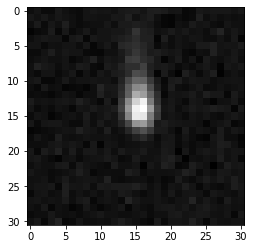

In [9]:
plt.imshow(img, cmap='gray');

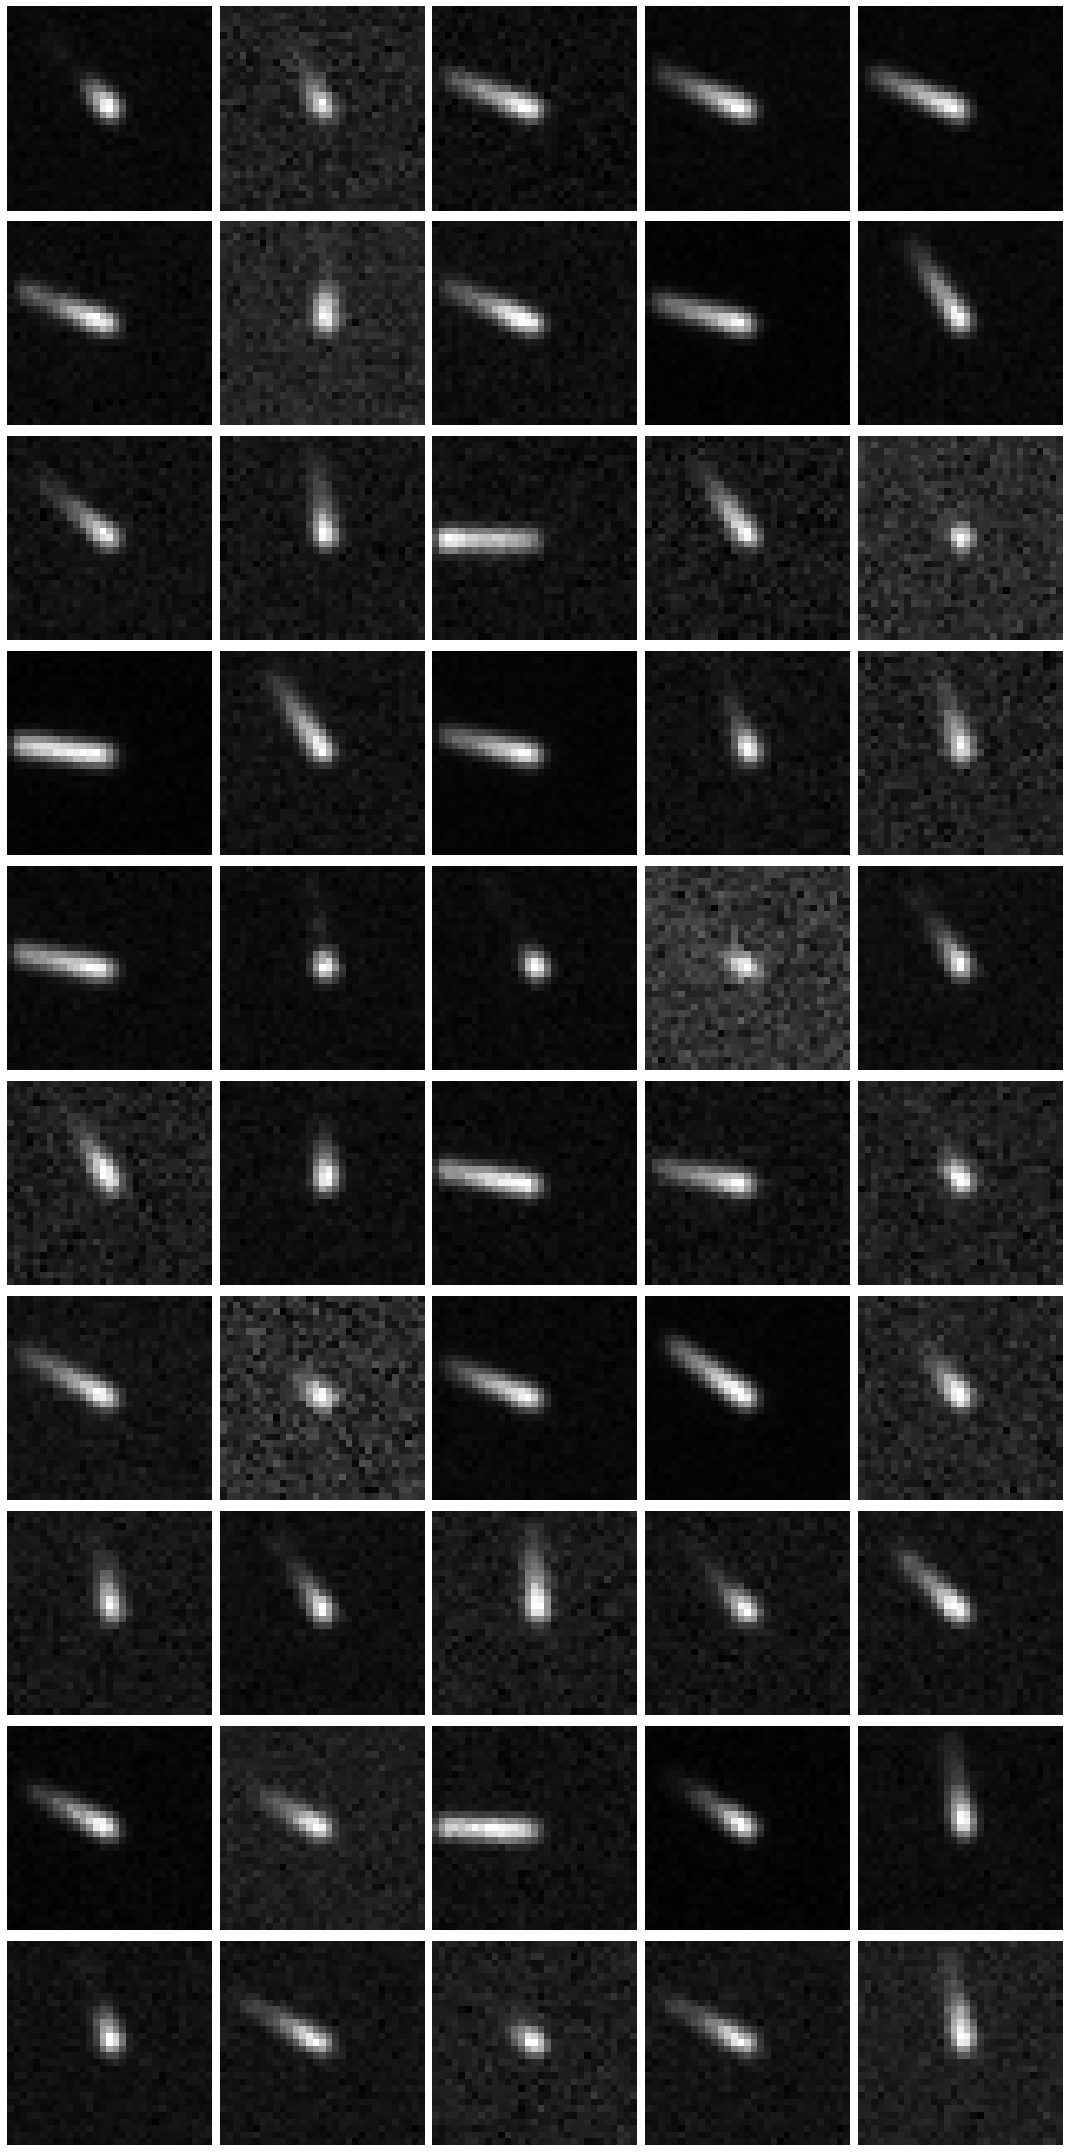

In [10]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(images))
        img, _ = read_tif(images[idx])
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout();

# Augmentation

In [9]:
import cv2

In [13]:
images = glob.glob('/Users/aman/Desktop/FADS/data_A/comet_*.tif')
img, meta = read_tif(images[100])
img.shape, meta

((31, 31),
 {'PolAng': 54,
  'TipProb': 0.543,
  'ExpTime': 102,
  'TipExp': 249,
  'eNoise': 201})

In [14]:
def plot_io(img, point):
    mask = np.zeros_like(img)
    mask[point] = 1
    
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')

In [15]:
imgc = img[:20, :20]

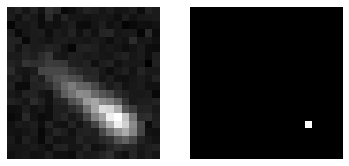

In [16]:
x, y = 15, 15
plot_io(imgc, (x, y))

### flip

In [39]:
def flip(img, point, subpixel=None, mode=0):
    # mode 0: horizontal flip, 1: vertical flip, 2: diagonal flip
    # TODO: incorporate subpixel
    h, w = img.shape
    if mode == 0:
        flip = cv2.flip(img, 1)
        point = (point[0], w-point[1]-1)
    elif mode == 1:
        flip = cv2.flip(img, 0)
        point = (h-point[0]-1, point[1])
    else:
        flip = cv2.flip(cv2.flip(img, 1), 0)
        point = (h-point[0]-1, w-point[1]-1)
    return flip, point #, subpixel

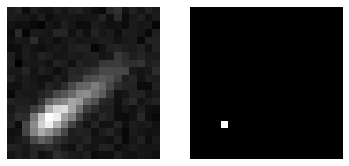

In [40]:
# flip horizontal
plot_io(*flip(imgc, (x, y), mode=0))

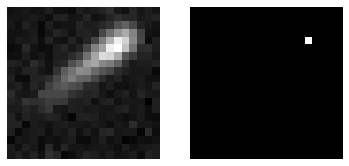

In [41]:
# flip vertical
plot_io(*flip(imgc, (x, y), mode=1))

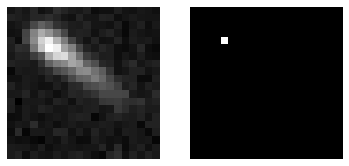

In [42]:
# flip diagonal
plot_io(*flip(imgc, (x, y), mode=2))

### crop

In [101]:
def crop(img, point):
    starti, startj = np.random.randint(0, 10, size=2)
    endi, endj = np.random.randint(18, 28, size=2)
    
    imgc = np.zeros_like(img) + img.mean()
    h, w = endi - starti, endj - startj
    imgc[:h, :w] = img[starti:endi, startj:endj]
    
    return imgc, (point[0] - starti, point[1] - startj)

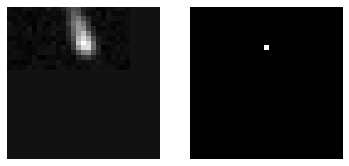

In [114]:
plot_io(*crop(img, (15, 15)))

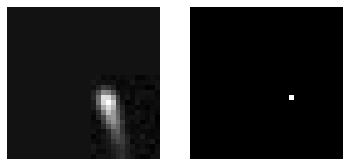

In [148]:
imgc, p = crop(img, (15, 15))
plot_io(*flip(imgc, p, mode=2))

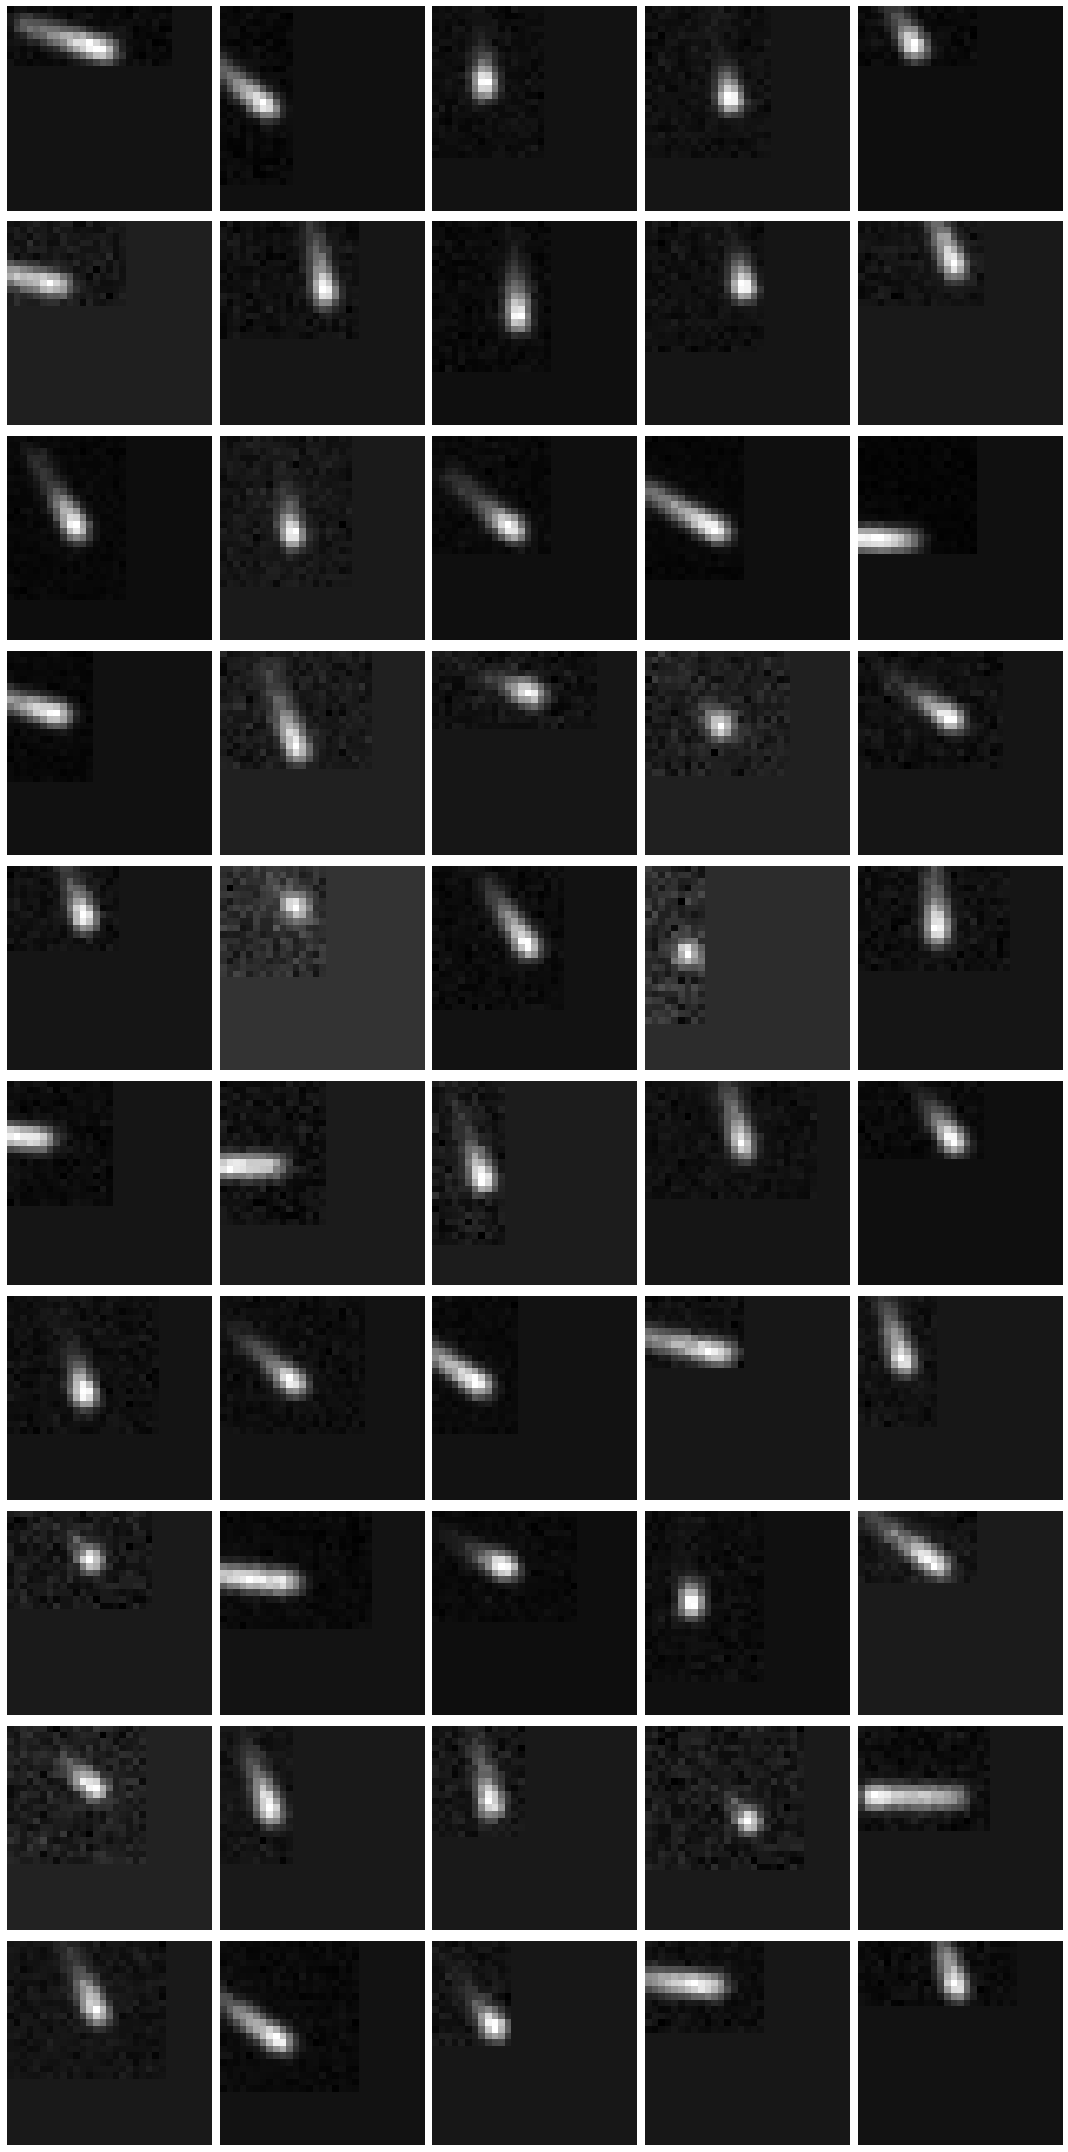

In [102]:
fig, ax = plt.subplots(10, 5, figsize=(15, 30))

for i in range(10):
    for j in range(5):
        idx = np.random.randint(0, len(images))
        img, _ = read_tif(images[idx])
        
        imgc, _ = crop(img, (15, 15))

        ax[i, j].imshow(imgc, cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout();